In [52]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [53]:
# Load data
df = pd.read_csv("datasets/Cyberattacks_5000.csv")

In [54]:
# Drop rows where target is null
target_column = 'Attacker type'
df.dropna(subset=[target_column], inplace=True)

In [55]:
# Drop irrelevant columns
drop_columns = [
    'Unnamed: 43', 'Organisation', 'Education and awareness policy', 'Policy',
    'Prevention, Detection and Recovery', 'Detector', 'Restructuring after attack',
    'Bribe/ransom paid', 'Free identity or credit theft monitoring', 'Additional disclosure of information',
    'Overall nature of attack', 'Individual(s) name(s) leaked/exposed', 'Address(es) leaked/exposed',
    'Other personally identifiable information (PII) leaked/exposed',
    'Track 1 - Credit card details leaked/exposed', 'Track 2 - Credit card details leaked/exposed',
    'Social security number/tax number leaked/exposed', 'Subsequent fraudulent use of data',
    'Investigation', 'Undertook investigation', 'Litigation by public', 'Penalties/settlement paid or actions imposed',
    'Imposed penalties or actions on organisation', 'Fines issued by government or relevant body',
    'Settlement paid', 'Effect on share price', 'Summary', 'Sector', 'Country', 'Year'
]

df.drop(columns=drop_columns, axis=1, inplace=True, errors='ignore')

In [56]:
# Fill missing values
df.fillna({
    'Organisation size': 'Unknown',
    'Improper network segmentation': 'Unknown',
    'Inappropriate remote access': 'Unknown',
    'Absence of encryption': 'Unknown',
    'Attack vector': 'Unknown',
    'Attack type': 'Unknown'
}, inplace=True)

In [57]:
# Feature and target separation
X = df.drop(columns=[target_column])    
y = df[target_column]

categorical = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(include=['number']).columns.tolist()

In [58]:
# Encode categorical features
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [59]:
# Feature selection with Random Forest
model = RandomForestClassifier()
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10).index
X_top = X[top_features]

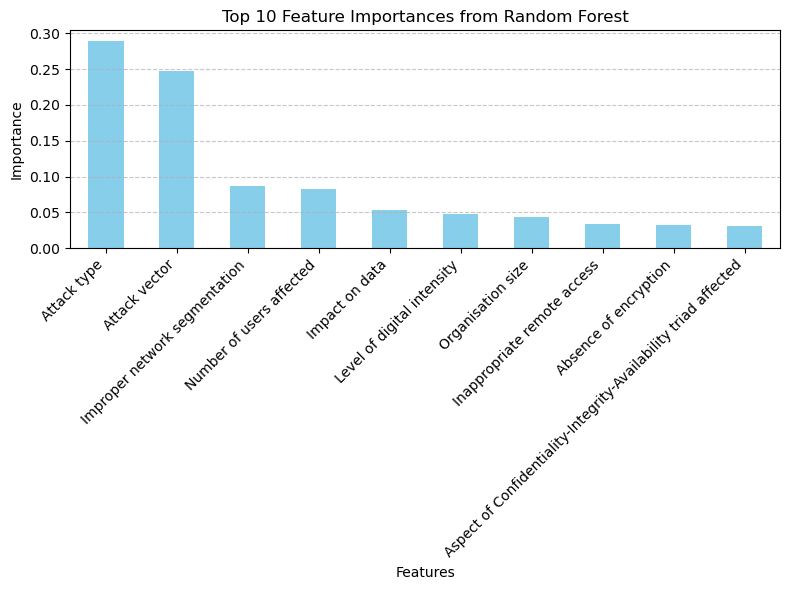

In [60]:
# Visualization of top features
plt.figure(figsize=(8, 6))
importances[top_features].plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [61]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

In [62]:
# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [63]:
# Predict and evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.979
Classification Report:
                            precision    recall  f1-score   support

      Cybercriminal group       0.97      0.96      0.97       149
Insider or Physical theft       0.99      1.00      0.99       157
       Nation-state actor       1.00      1.00      1.00         1
                  Phisher       0.95      0.97      0.96        75
  Script kiddie or Hacker       0.96      0.96      0.96        56
              Third-party       0.88      1.00      0.93        21
                  Unknown       0.99      0.98      0.98       541

                 accuracy                           0.98      1000
                macro avg       0.96      0.98      0.97      1000
             weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
 [[143   0   0   0   2   0   4]
 [  0 157   0   0   0   0   0]
 [  0   0   1   0   0   0   0]
 [  0   0   0  73   0   0   2]
 [  0   0   0   0  54   2   0]
 [  0   0   0   0   0  21   0]
 [  4   2   0  

In [64]:
cm = confusion_matrix(y_test, y_pred)
print(cm)  # Check shape

[[143   0   0   0   2   0   4]
 [  0 157   0   0   0   0   0]
 [  0   0   1   0   0   0   0]
 [  0   0   0  73   0   0   2]
 [  0   0   0   0  54   2   0]
 [  0   0   0   0   0  21   0]
 [  4   2   0   4   0   1 530]]


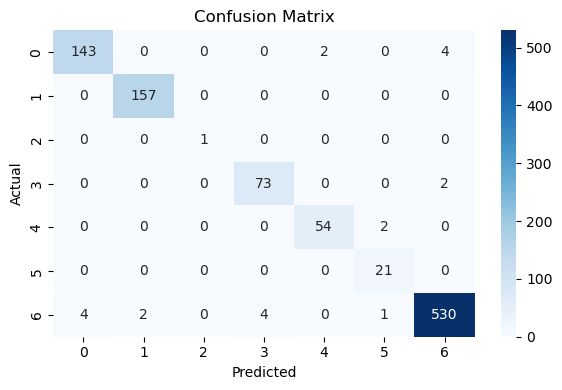

In [65]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [66]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

In [67]:
# Evaluation with Hyperparameter Tuning
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.979
Classification Report:
                            precision    recall  f1-score   support

      Cybercriminal group       0.97      0.96      0.97       149
Insider or Physical theft       0.99      1.00      0.99       157
       Nation-state actor       1.00      1.00      1.00         1
                  Phisher       0.95      0.97      0.96        75
  Script kiddie or Hacker       0.96      0.96      0.96        56
              Third-party       0.88      1.00      0.93        21
                  Unknown       0.99      0.98      0.98       541

                 accuracy                           0.98      1000
                macro avg       0.96      0.98      0.97      1000
             weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
 [[143   0   0   0   2   0   4]
 [  0 157   0   0   0   0   0]
 [  0   0   1   0   0   0   0]
 [  0   0   0  73   0   0   2]
 [  0   0   0   0  54   2   0]
 [  0   0   0   0   0  21   0]
 [  4   2   0  

In [68]:
# # Save model and encoders
# os.makedirs('models', exist_ok=True)
# # joblib.dump(label_encoders, 'models/label_encoder.joblib')
# joblib.dump(rf, 'models/random_forest.joblib')
# joblib.dump(top_features, 'models/feature_selection.joblib')